## Project 3

## Stirred


## Group 1 9:

- Mussa Banjai
- Tapas Dev
- Jason Kapka
- Taz Ahmed

## Introduction

This project focuses on applying numerical analysis on a set of ordinary differential equations (ODEs) to replicate the results from a 3D computational fluid dynamics (CFD) simulation. The specific phenomena we are attempting to model is related to fluid flow within the body for a specific health care application.

The Navier-Stokes (NS) equations are utilized as a basis for nearly all CFD problems [https://en.wikipedia.org/wiki/Computational_fluid_dynamics]. They are derived using the principles of conservation of momentum and conservation of mass. The NS equations assume that the fluid is infinitely divisible, so it may not be applicable and very small scales dealing with molecular level flow.

The accuracy of CFD analysis is limited by the following widely accepted terms [H.K.Versteeg and W.Malalasekera, An Introduction to Computational Fluid Dynamics]:
* Error
  * Numerical errors
  * Coding errors
  * User errors
* • Uncertainty
  * Input uncertainty
  * Physical model uncertainty

The results from CFD analysis are highly dependent on the mesh size and type. Attempts to effectively model very large systems, such as all the pores in a 100 m thick oil reservoir or all the 100000 km of blood vessels in a human body, in realistic time-frame using commercially available CFD software and computing power would require such a large mesh size that it would likely lead to significant physical model uncertainty. For this reason, attempting to build a simple homemade fluid flow model is non-trivial if it has the potential for scalability beyond the practical limits of CFD analysis.

The learning objectives of this project are as follows:
* Create an ordinary differential equation solver which utilizes the Euler, 2nd order Runge-Kutta, and 4th order Runge-Kutta algorithms
* Attempt to model the medical tracer concentration through an aorta arch as a series of well-mixed continuously stirred tank reactors (CSTRs)
* Compare our model results to those from a CFD simulation and try to determine the arch volume and cardiac output / flooding rate
* See if the tracer output can be used to indicate whether the aorta is healthy or has an aneurysm


## Libraries

In [16]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## ODE Solver class

In [17]:
class ODE_solver:
    def __init__(self, tanks, Tf, dt, tau, c_ini, flowrate = 5, T_ini = 0, h =0.02, M_inj = 0.083333):
        self.n = tanks # No. of Tanks
        self.T_ini = T_ini #Initial Time (s)
        self.Tf = Tf # Final Time (s)
        self.dt = dt # Time step (s)
        self.h = h
        self.M_inj = M_inj
        self.tau = tau
        self.q = flowrate
        self.V_total = self.tau * self.q #Total volume of all tanks (m^3)
        self.V = self.V_total/self.n #Volume of 1 tank (m^3)
        self.time = np.arange(self.T_ini, self.Tf+self.dt, self.dt)
        self.Cin = np.zeros(len(self.time))
        self.c_ini = c_ini

    """
    This is the function that it will be used on following methods: euler, rk2 and rk4
    """
    def rhs(self, C, t, protocol):
        rhs = []
        tank = 0
        c_in = self.c_inj(protocol)[self.count]
        #print(c_in)
        while tank < self.n:
            if tank == 0:
                rhs.append(c_in - C[0])
            else:
                rhs.append(C[tank - 1] - C[tank])
            tank+= 1

        return np.array(rhs)*self.n/self.tau


    def rhs_extended(self, C, t, protocol, C_a):
        rhs = []
        tank = 0
        c_in = self.c_inj(protocol)[self.count]
        D = 0.2*self.q
        V_a = 0.5*self.V
        #print(c_in)
        while tank < self.n:
            if tank == 0:
                rhs.append(c_in - C[0])
            elif tank == self.n - 3:
                C_a = C_a + self.rk4_Ca(C_a, t, D, V_a, C[tank])
                sol = (C[tank - 1] - C[tank]) - ((D/self.q)*(C[tank] - C_a))
                #print(tank, sol)
                rhs.append(sol)
            else:
                rhs.append(C[tank - 1] - C[tank])
            tank+= 1

        return np.array(rhs)*self.n/self.tau

    def rhs_Ca(self, C_a, t, D, Va, C):
        return (D/Va)*(C - C_a)

    def rk4_Ca(self, y, t, D, Va, C):
        k1=self.dt*self.rhs_Ca(y,t, D, Va, C)
        k2=self.dt*self.rhs_Ca(y+0.5*k1,t+0.5*self.dt, D, Va, C)
        k3=self.dt*self.rhs_Ca(y+0.5*k2,t+0.5*self.dt, D, Va, C)
        k4=self.dt*self.rhs_Ca(y+k3,t+self.dt, D, Va, C)
        return (k1+2*k2+2*k3+k4)/6


    """
    Euler method
    """
    def euler_step(self, y, t, protocol):
        return self.dt*self.rhs(y, t, protocol)

    """
    Runge-Kutta second order
    """
    def rk2_step(self,y,t, protocol):
        k1=self.dt*self.rhs(y,t, protocol)
        k2=self.dt*self.rhs(y+0.5*k1,t+self.dt*0.5, protocol)
        return k2

    """
    Runge-Kutta fourth order
    """
    def rk4_step(self,y,t, protocol):
        k1=self.dt*self.rhs(y,t, protocol)
        k2=self.dt*self.rhs(y+0.5*k1,t+0.5*self.dt, protocol)
        k3=self.dt*self.rhs(y+0.5*k2,t+0.5*self.dt, protocol)
        k4=self.dt*self.rhs(y+k3,t+self.dt, protocol)
        return (k1+2*k2+2*k3+k4)/6

    def rk4_step_extended(self,y,t, protocol, C_a):
            k1=self.dt*self.rhs_extended(y,t, protocol, C_a)
            k2=self.dt*self.rhs_extended(y+0.5*k1,t+0.5*self.dt, protocol, C_a)
            k3=self.dt*self.rhs_extended(y+0.5*k2,t+0.5*self.dt, protocol, C_a)
            k4=self.dt*self.rhs_extended(y+k3,t+self.dt, protocol, C_a)
            return (k1+2*k2+2*k3+k4)/6


    """
    Here it returns the step based on method
    """
    def step(self, y,t,method, protocol):
        if method == 'euler':
            return self.dt*self.rhs(y,t, protocol)
        elif method == 'rk2':
            return self.rk2_step(y,t, protocol)
        elif method == 'rk4':
            return self.rk4_step(y,t, protocol)
        else:
            print('unknown method')

    def solver(self, method, protocol):
        y_old=self.c_ini
        sol=[]
        count = 0
        for t in self.time:
            self.count = count
            #print(count)
            sol.append(y_old)
            y_next=y_old+self.step(y_old,t,method, protocol)
            y_old=y_next
            count += 1
        return self.time ,np.array(sol)[:,-1]

    def solver_extended(self, protocol):
        y_old=self.c_ini
        sol=[]
        count = 0
        C_a = 0
        for t in self.time:
            self.count = count
            #print(count)
            sol.append(y_old)
            y_next=y_old+self.rk4_step_extended(y_old,t, protocol, C_a)
            y_old=y_next
            count += 1
        return self.time ,np.array(sol)[:,-1]
    
    def analytical(self):
        sol = []
        for t in self.time:
            if self.n == 1:
                sol.append(np.exp(-t/self.tau))
            if self.n == 2:
                sol.append((2*t/self.tau)*np.exp(-2*t/self.tau))
            if self.n == 3:
                sol.append(((9*t**2)/(2*self.tau**2))*np.exp(-3*t/self.tau))
        return self.time, np.array(sol)


    
    """
    C injection based on protocol
    """
    def c_inj(self, protocol):
        if protocol == 0:
            ti = np.array([0,1.,2.,3.])
            Cin = np.array([0,0,0,0])
            return np.interp(self.time,ti, Cin, right= 0)
        if protocol == 1:
            ti = np.array([0, 1., 1.,2., 3. ])
            Cin = np.array([1.,1.,0,0,0])
            return np.interp(self.time,ti, Cin, right= 0)
        if protocol == 2:
            ti = np.array([0, 2., 3., 3., 4])
            Cin = np.array([1., 1., 1., 0, 0])
            return np.interp(self.time,ti, Cin, right= 0)   
        if protocol == 3:
            ti = np.array([0, 1., 1.,2., 3. ])
            Cin = np.array([0,1.,0,0,0])
            return np.interp(self.time,ti, Cin, right= 0)
        if protocol == 4:
            ti = np.array([0, 1., 1.,2., 2., 3.,3.,4. ])
            Cin = np.array([0.7,0.7,0,0,1, 1, 0, 0])
            return np.interp(self.time,ti, Cin, right= 0)


    """
    This function reads the healthy data
    """
    def Healty_Data(self, protocol):
        if protocol==1:
            dt_rec1s = pd.read_csv("data/Healthy_rect_1s.csv", delimiter=",")
            concentration = dt_rec1s["Concentration"]
            time = dt_rec1s["Time"]
            return dt_rec1s

        if protocol==2:
            dt_rec3s = pd.read_csv("data/Healthy_rect_3s.csv", delimiter=",")
            concentration = dt_rec3s["Concentration"]
            time = dt_rec3s["Time"]
            return dt_rec3s

        if protocol==3:
            dt_ramp1s = pd.read_csv("data/Healthy_ramp_1s.csv", delimiter=",")
            concentration = dt_ramp1s["Concentration"]
            time = dt_ramp1s["Time"]
            return dt_ramp1s

        if protocol==4:
            dt_biphasic = pd.read_csv("data/Healthy_biphasic.csv", delimiter=",")
            concentration = dt_biphasic["Concentration"]
            time = dt_biphasic["Time"]
            return dt_biphasic


    """
    This function reads the aneurysm data
    """
    def Aneurysm_Data(self, protocol):
        if protocol==1:
            dt_a_dt_rec1s = pd.read_csv("data/Aneurysm_rect_1s.csv", delimiter=",")
            concentration = dt_a_dt_rec1s["Concentration"]
            time = dt_a_dt_rec1s["Time"]
            return dt_a_dt_rec1s

        if protocol==2:
            dt_a_dt_rec3s = pd.read_csv("data/Aneurysm_rect_3s.csv", delimiter=",")
            concentration = dt_a_dt_rec3s["Concentration"]
            time = dt_a_dt_rec3s["Time"]
            return dt_a_dt_rec3s

        if protocol==3:
            dt_a_ramp1s = pd.read_csv("data/Aneurysm_ramp_1s.csv", delimiter=",")
            concentration = dt_a_ramp1s["Concentration"]
            time = dt_a_ramp1s["Time"]
            return dt_a_ramp1s

        if protocol==4:
            dt_a_biphasic = pd.read_csv("data/Aneurysm_biphasic.csv", delimiter=",")
            concentration = dt_a_biphasic["Concentration"]
            time = dt_a_biphasic["Time"]
            return dt_a_biphasic
    

    def flowrate_q(self):
        dt_rec1s = self.Healty_Data(1)
        f_a = dt_rec1s['Concentration'].iloc[0]
        f_b = dt_rec1s['Concentration'].iloc[-1]
        f_all = np.sum(dt_rec1s['Concentration'].iloc[1:-2])
        c_out = self.h*((f_a+f_b)/2 + (f_all))
        return round((self.M_inj/c_out)*60)   # multiply by 60 to convert into minutes

## Exercise

### Exercise 1

##### Part 1

Check the class

#### Part 2

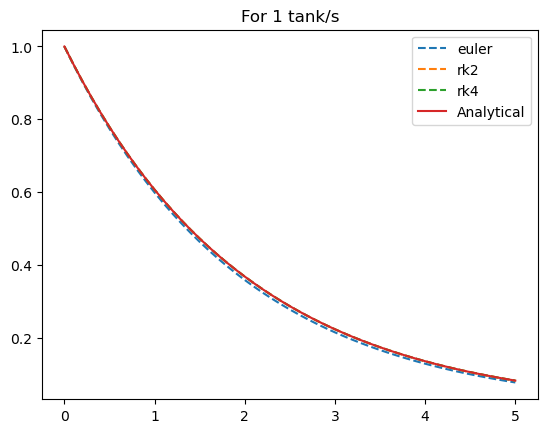

In [18]:
n = 1
Cini = np.zeros(n)
Cini[0] = 1
tau  = 2 # To make the value of tau = 2, with flow rate = 5
total_time = 5
time_step = 0.1
OD = ODE_solver(n, total_time, time_step, tau, c_ini=Cini)
t1, s1 = OD.solver('euler', 0)
t2, s2 = OD.solver('rk2', 0)
t3, s3 = OD.solver('rk4', 0)
t, s = OD.analytical()

plt.plot(t1, s1, '--', label = 'euler')
plt.plot(t2, s2, '--', label = 'rk2')
plt.plot(t3, s3, '--', label = 'rk4')
plt.plot(t, s, label = 'Analytical')
plt.title('For {} tank/s'.format(n))
plt.legend()

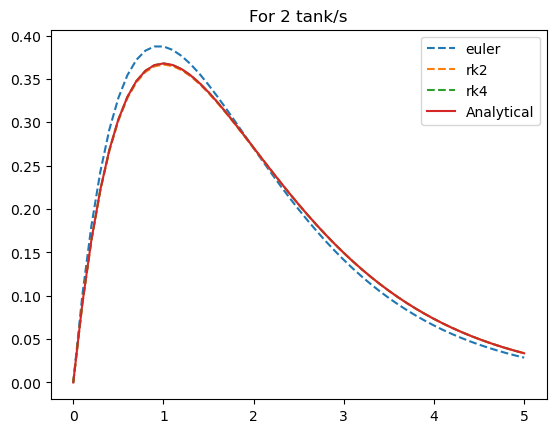

In [19]:
n = 2
Cini = np.zeros(n)
Cini[0] = 1
tau  = 2 # To make the value of tau = 2, with flow rate = 5
total_time = 5
time_step = 0.1
OD = ODE_solver(n, total_time, time_step, tau, c_ini=Cini)
t1, s1 = OD.solver('euler', 0)
t2, s2 = OD.solver('rk2', 0)
t3, s3 = OD.solver('rk4', 0)
t, s = OD.analytical()

plt.plot(t1, s1, '--', label = 'euler')
plt.plot(t2, s2, '--', label = 'rk2')
plt.plot(t3, s3, '--', label = 'rk4')
plt.plot(t, s, label = 'Analytical')
plt.title('For {} tank/s'.format(n))
plt.legend()

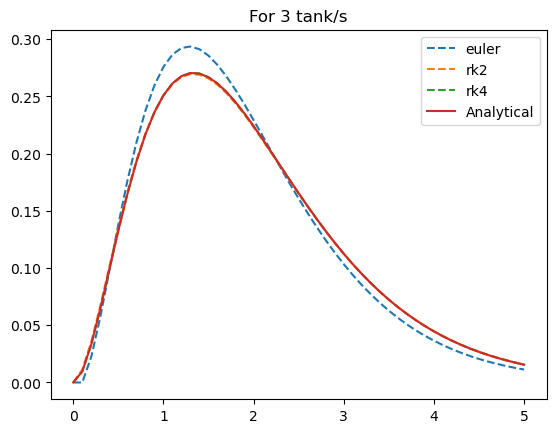

In [20]:
n = 3
Cini = np.zeros(n)
Cini[0] = 1
tau  = 2 # To make the value of tau = 2, with flow rate = 5
total_time = 5
time_step = 0.1
OD = ODE_solver(n, total_time, time_step, tau, c_ini=Cini)
t1, s1 = OD.solver('euler', 0)
t2, s2 = OD.solver('rk2', 0)
t3, s3 = OD.solver('rk4', 0)
t, s = OD.analytical()

plt.plot(t1, s1, '--', label = 'euler')
plt.plot(t2, s2, '--', label = 'rk2')
plt.plot(t3, s3, '--', label = 'rk4')
plt.plot(t, s, label = 'Analytical')
plt.title('For {} tank/s'.format(n))
plt.legend()

#### Part 3

##### I

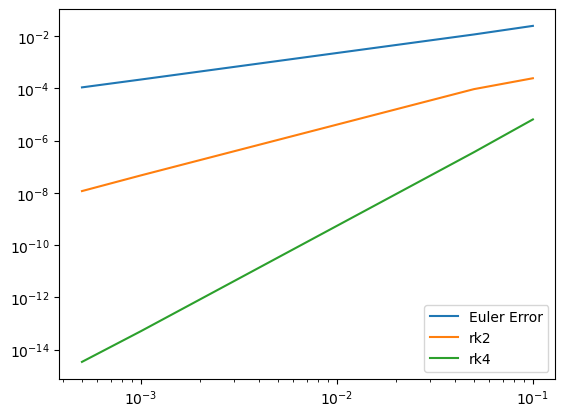

In [21]:
DT = [0.1, 0.05, 0.001, 0.0005]
error1 = []
error2 = []
error3 = []
total_time = 1
for dt in DT:
    OD = ODE_solver(n, total_time, dt, tau, c_ini=Cini)
    t1, s1 = OD.solver('euler', 0)
    t2, s2 = OD.solver('rk2', 0)
    t3, s3 = OD.solver('rk4', 0)
    t, s = OD.analytical()
    
    err1 = np.abs(s1[np.where(t1 == 1)][0] - s[np.where(t == 1)][0])
    err2 = np.abs(s2[np.where(t2 == 1)][0] - s[np.where(t == 1)][0])
    err3 = np.abs(s3[np.where(t3 == 1)][0] - s[np.where(t == 1)][0])


    error1.append(err1)
    error2.append(err2)
    error3.append(err3)

plt.plot(DT, error1, label = 'Euler Error')
plt.plot(DT, error2, label = 'rk2')
plt.plot(DT, error3, label = 'rk4')
plt.xscale('log')
plt.yscale('log')
plt.legend()

##### II

The numerical errors of the ODE solver scaled as expected with the 4th order Runge-Kutta method being the most accurate and steepest error reduction, and the Euler method being the least accurate and the flattest error reduction.

This makes sense since the Euler method is the most simple approximation method and is accurate to $h$, while the 2nd and 4th order Runge-Kutta methods are more involved with intermediate substeps which results in $h^3$ and $h^5$ accuracies.
I wouls just past both of those statements.

### Exercise 2

#### Part 1

Data

In [22]:
healthy_rect_1s = pd.read_csv("data/Healthy_rect_1s.csv", delimiter=",")
hconcentration = healthy_rect_1s["Concentration"]
htime = healthy_rect_1s["Time"]
healthy_rect_1s

,Time,Concentration
0,0.00,0.000000e+00
1,0.02,0.000000e+00
2,0.04,0.000000e+00
3,0.06,0.000000e+00
4,0.08,0.000000e+00
...,...,...
246,4.92,8.620000e-06
247,4.94,4.980000e-06
248,4.96,2.020000e-06
249,4.98,2.510000e-08


In [23]:
Minj = 83.33 # grams
Q =  np.trapz(hconcentration, x=htime) # integral of concentration over time
q = Minj/Q

"""
The solution is in g/sec. Needs to convert to L/min
1 g/s = 0.060 L/min
"""
q = q*0.06
q

5.005803448030458

#### Part 2

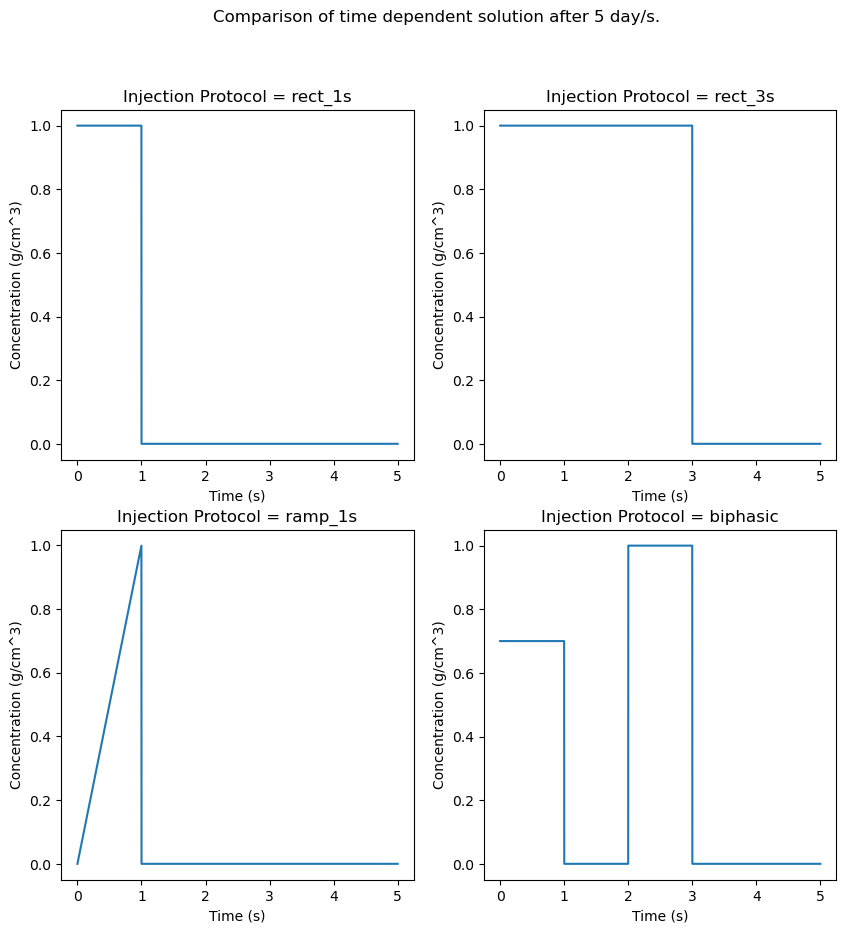

In [24]:
total_time = 5
time_step = 0.001
tau = 2
OD = ODE_solver(n, total_time, time_step, tau, c_ini=Cini)
fig, axs = plt.subplots(2,2, figsize = (10,10))
fig.suptitle('Comparison of time dependent solution after {} day/s.'.format(total_time))
i = 0
protocol = ['rect_1s', 'rect_3s', 'ramp_1s', 'biphasic']

while i < 4:
    cinj = OD.c_inj(i+1)
    l = 1 if i >=2 else 0
    m = 1 if i == 1 or i == 3 else 0
    axs[l, m].plot(OD.time, cinj, '-')
    axs[l, m].set_title('Injection Protocol = {}'.format(protocol[i]))
    axs[l, m].set(xlabel="Time (s)",ylabel="Concentration (g/cm^3)")
    i+= 1

#### Part 3

In [25]:
h = OD.Healty_Data(1)
x = h['Time'].values
y = h['Concentration'].values
q = OD.flowrate_q()
tanks = [48, 49, 50, 51, 52, 53, 54]
for n in tanks:

    def test_func(q, tau):
    
        Cini = np.zeros(int(n))
        total_time = 5
        time_step = 0.02
        flow_rate = q
        OD = ODE_solver(n, total_time, time_step, tau, Cini, flowrate= flow_rate)
        _, s = OD.solver('rk4', 1)
        return s

    t, cov = sp.optimize.curve_fit(test_func, x, y)

    print(n, t, cov)

48 [2.36571218] [[1.64612428e-06]]
49 [2.36549968] [[1.60311614e-06]]
50 [2.36529219] [[1.63588228e-06]]
51 [2.36508939] [[1.73509405e-06]]
52 [2.3648911] [[1.89255047e-06]]
53 [2.36469696] [[2.10101511e-06]]
54 [2.36450678] [[2.35410947e-06]]


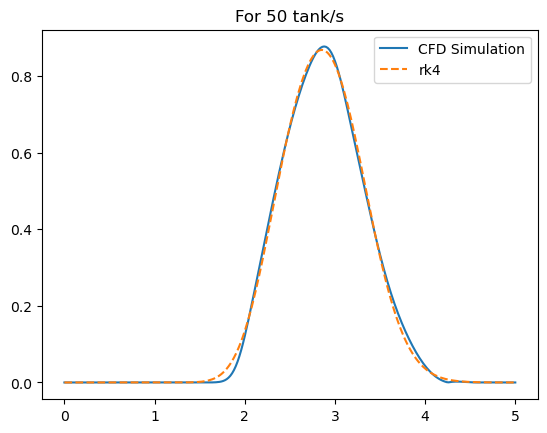

In [26]:
n = 50
Cini = np.zeros(n)
tau = 2.36549968 # To make the value of tau = 2, with flow rate = 5
total_time = 5
time_step = 0.02
OD = ODE_solver(n, total_time, time_step, tau, c_ini=Cini)
t, s = OD.solver('rk4', 1)
h_rec1s = OD.Healty_Data(1) # 1 is for healty rect1s
plt.plot(h_rec1s['Time'], h_rec1s['Concentration'], label = 'CFD Simulation')
plt.plot(t, s, '--', label = 'rk4')

plt.title('For {} tank/s'.format(n))
plt.legend()

#### Part 4

In [27]:
h = OD.Healty_Data(1)
x = h['Time'].values
y = h['Concentration'].values
q = OD.flowrate_q()
tanks = [48, 49, 50, 51, 52, 53, 54]
for n in tanks:

    def test_func(q, tau):
    
        Cini = np.zeros(int(n))
        total_time = 5
        time_step = 0.02
        flow_rate = q
        OD = ODE_solver(n, total_time, time_step, tau, Cini, flowrate= flow_rate)
        _, s = OD.solver('rk4', 1)
        return s

    t, cov = sp.optimize.curve_fit(test_func, x, y)

    print(n, t, cov)

48 [2.36571218] [[1.64612428e-06]]
49 [2.36549968] [[1.60311614e-06]]
50 [2.36529219] [[1.63588228e-06]]
51 [2.36508939] [[1.73509405e-06]]
52 [2.3648911] [[1.89255047e-06]]
53 [2.36469696] [[2.10101511e-06]]
54 [2.36450678] [[2.35410947e-06]]


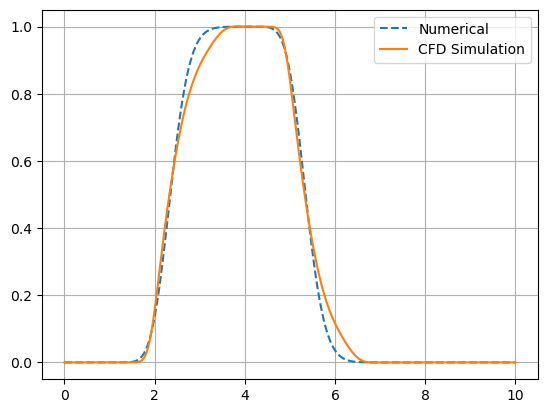

In [28]:
n = 50
tau = 2.36549968
total_time = 10
OD = ODE_solver(n, total_time, time_step, tau, Cini)
t, s = OD.solver('rk4', 2)

h_rec3s = OD.Healty_Data(2)
#print(t, s)
plt.plot(t, s, '--', label = 'Numerical')
plt.plot(h_rec3s['Time'], h_rec3s['Concentration'], label = 'CFD Simulation')
plt.legend()
plt.grid()

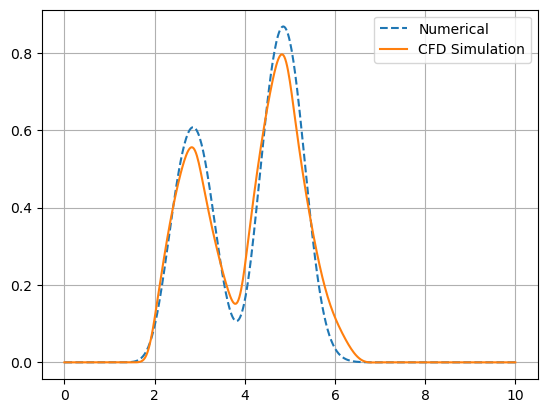

In [29]:
OD = ODE_solver(n, total_time, time_step, tau, Cini)
t, s = OD.solver('rk4', 4)

h_rec1s = OD.Healty_Data(4) # 1 is for healty rect1s

plt.plot(t, s, '--', label = 'Numerical')
plt.plot(h_rec1s['Time'], h_rec1s['Concentration'], label = 'CFD Simulation')
plt.legend()
plt.grid()

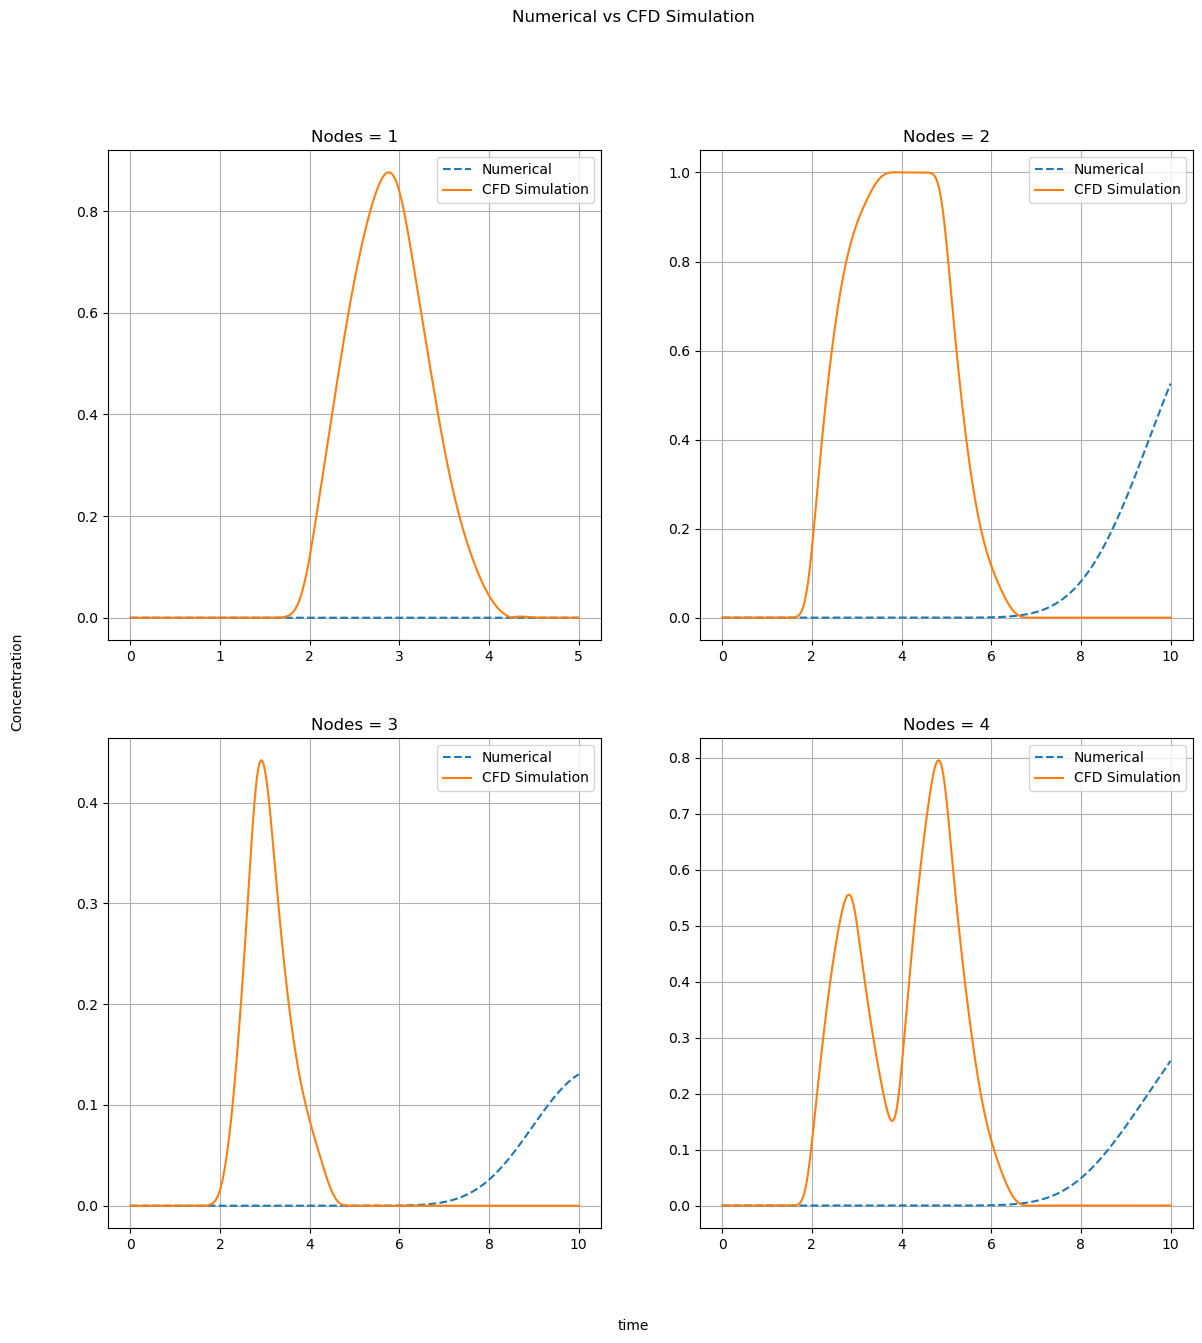

In [30]:
N = [1,2,3,4]
total_time = [5, 10, 10, 10]
fig, axs = plt.subplots(2,2, figsize = (14,14))
fig.suptitle('Numerical vs CFD Simulation')
fig.text(0.5, 0.04, 'time', ha='center', va='center')
fig.text(0.06, 0.5, 'Concentration', ha='center', va='center', rotation='vertical')
# Making subplots for different step sizes
i = 0
while i < len(N):
    n = 48
    Cini = np.zeros(n)
    time_step = 0.02
    V_total = 9.931025
    OD = ODE_solver(n, total_time[i], time_step, V_total, Cini)
    t, s = OD.solver('rk4', N[i])
    CFD = OD.Healty_Data(N[i])

    if i == 0:
        axs[0, 0].plot(t, s, '--', label = 'Numerical')
        axs[0, 0].plot(CFD['Time'], CFD['Concentration'], label = 'CFD Simulation')
        axs[0,0].set_title('Nodes = {}'.format(N[i]))
        axs[0,0].legend()
        axs[0,0].grid()
    elif i == 1:
        axs[0, 1].plot(t, s, '--', label = 'Numerical')
        axs[0, 1].plot(CFD['Time'], CFD['Concentration'], label = 'CFD Simulation')
        axs[0, 1].set_title('Nodes = {}'.format(N[i]))
        axs[0, 1].legend()
        axs[0, 1].grid()
    elif i == 2:
        axs[1, 0].plot(t, s, '--', label = 'Numerical')
        axs[1, 0].plot(CFD['Time'], CFD['Concentration'], label = 'CFD Simulation')
        axs[1, 0].set_title('Nodes = {}'.format(N[i]))
        axs[1, 0].legend()
        axs[1, 0].grid()
    elif i == 3:
        axs[1, 1].plot(t, s, '--', label = 'Numerical')
        axs[1, 1].plot(CFD['Time'], CFD['Concentration'], label = 'CFD Simulation')
        axs[1, 1].set_title('Nodes = {}'.format(N[i]))
        axs[1, 1].legend()
        axs[1, 1].grid()
    i+= 1

After tuning the CSTR model with n=50 tanks and tau=2.36549968 to best fit the Healthy_rect_1s.csv CFD data, forecasts were made to predict the healthy aorta flow results from the rect_3s, ramp_1s, and biphasic injection protocols with good accuracy as shown in the plots above.  The slope of the initial concentration increase matches very well for these three other protocols, while the shape of the peaks and decreasing slope deviate slightly from the CFD simulations. Perhaps in the introduction of an additional parameter, or  by varying the volume distribution of the tanks in series, the model could be further refined to give a closer match.

### Exercise 3

#### Part 1

In [31]:
h = OD.Aneurysm_Data(1)
x = h['Time'].values
y = h['Concentration'].values
q = OD.flowrate_q()
tanks = [20, 21, 22, 23, 24, 25]
for n in tanks:

    def test_func(q, tau):
    
        Cini = np.zeros(int(n))
        total_time = 5
        time_step = 0.02
        flow_rate = q
        OD = ODE_solver(n, total_time, time_step, tau, Cini, flowrate= flow_rate)
        _, s = OD.solver('rk4', 1)
        return s

    p, cov = sp.optimize.curve_fit(test_func, x, y)

    print(n, p, cov)

20 [2.45690557] [[5.23753823e-05]]
21 [2.45476903] [[4.86626685e-05]]
22 [2.45281711] [[4.66499982e-05]]
23 [2.45102166] [[4.59107209e-05]]
24 [2.44936068] [[4.61258973e-05]]
25 [2.44781477] [[4.70535018e-05]]


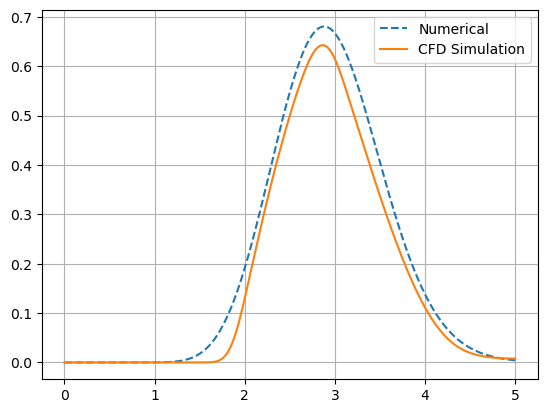

In [32]:
n = 23
tau = 2.45102166
Cini = np.zeros(n)
total_time = 5
time_step = 0.02
OD = ODE_solver(n, total_time, time_step, tau, Cini)
t, s = OD.solver('rk4', 1)

h_rec1s = OD.Aneurysm_Data(1)
#print(t, s)
plt.plot(t, s, '--', label = 'Numerical')
plt.plot(h_rec1s['Time'], h_rec1s['Concentration'], label = 'CFD Simulation')
plt.legend()
plt.grid()

#### Part 2

In [33]:
h = OD.Aneurysm_Data(1)
x = h['Time'].values
y = h['Concentration'].values
q = OD.flowrate_q()
tanks = [20, 21, 22, 23, 24, 25]
for n in tanks:

    def test_func(q, tau):
    
        Cini = np.zeros(int(n))
        total_time = 5
        time_step = 0.02
        flow_rate = q
        OD = ODE_solver(n, total_time, time_step, tau, Cini, flowrate= flow_rate)
        _, s = OD.solver('rk4', 1)
        return s

    p, cov = sp.optimize.curve_fit(test_func, x, y)

    print(n, p, cov)

20 [2.45690557] [[5.23753823e-05]]
21 [2.45476903] [[4.86626685e-05]]
22 [2.45281711] [[4.66499982e-05]]
23 [2.45102166] [[4.59107209e-05]]
24 [2.44936068] [[4.61258973e-05]]
25 [2.44781477] [[4.70535018e-05]]


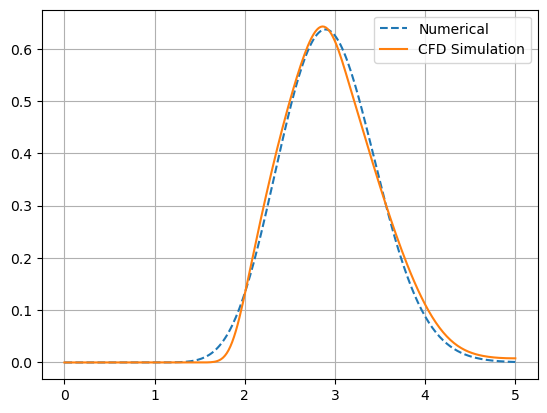

In [34]:
n = 31
tau = 2.45102166
Cini = np.zeros(n)
total_time = 5
time_step = 0.02
OD = ODE_solver(n, total_time, time_step, tau, Cini)
t, s = OD.solver_extended(1)

h_rec1s = OD.Aneurysm_Data(1)
#print(t, s)
plt.plot(t, s, '--', label = 'Numerical')
plt.plot(h_rec1s['Time'], h_rec1s['Concentration'], label = 'CFD Simulation')
plt.legend()
plt.grid()

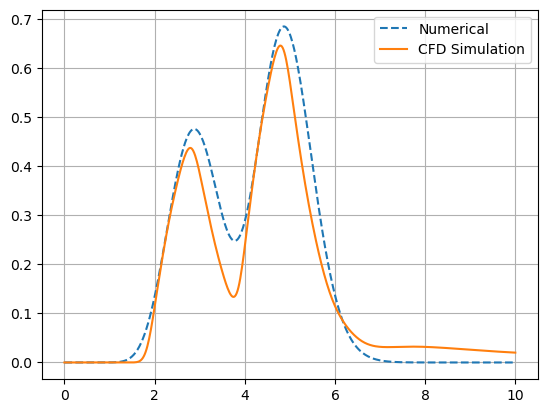

In [35]:
n = 23
tau = 2.45102166
Cini = np.zeros(n)
total_time = 10
time_step = 0.02
#V_total = 13 #11.45
OD = ODE_solver(n, total_time, time_step, tau, Cini)
t, s = OD.solver('rk4', 4)

h_rec1s = OD.Aneurysm_Data(4) # calling Aneurysm rect3s
#print(t, s)
plt.plot(t, s, '--', label = 'Numerical')
plt.plot(h_rec1s['Time'], h_rec1s['Concentration'], label = 'CFD Simulation')
plt.legend()
plt.grid()

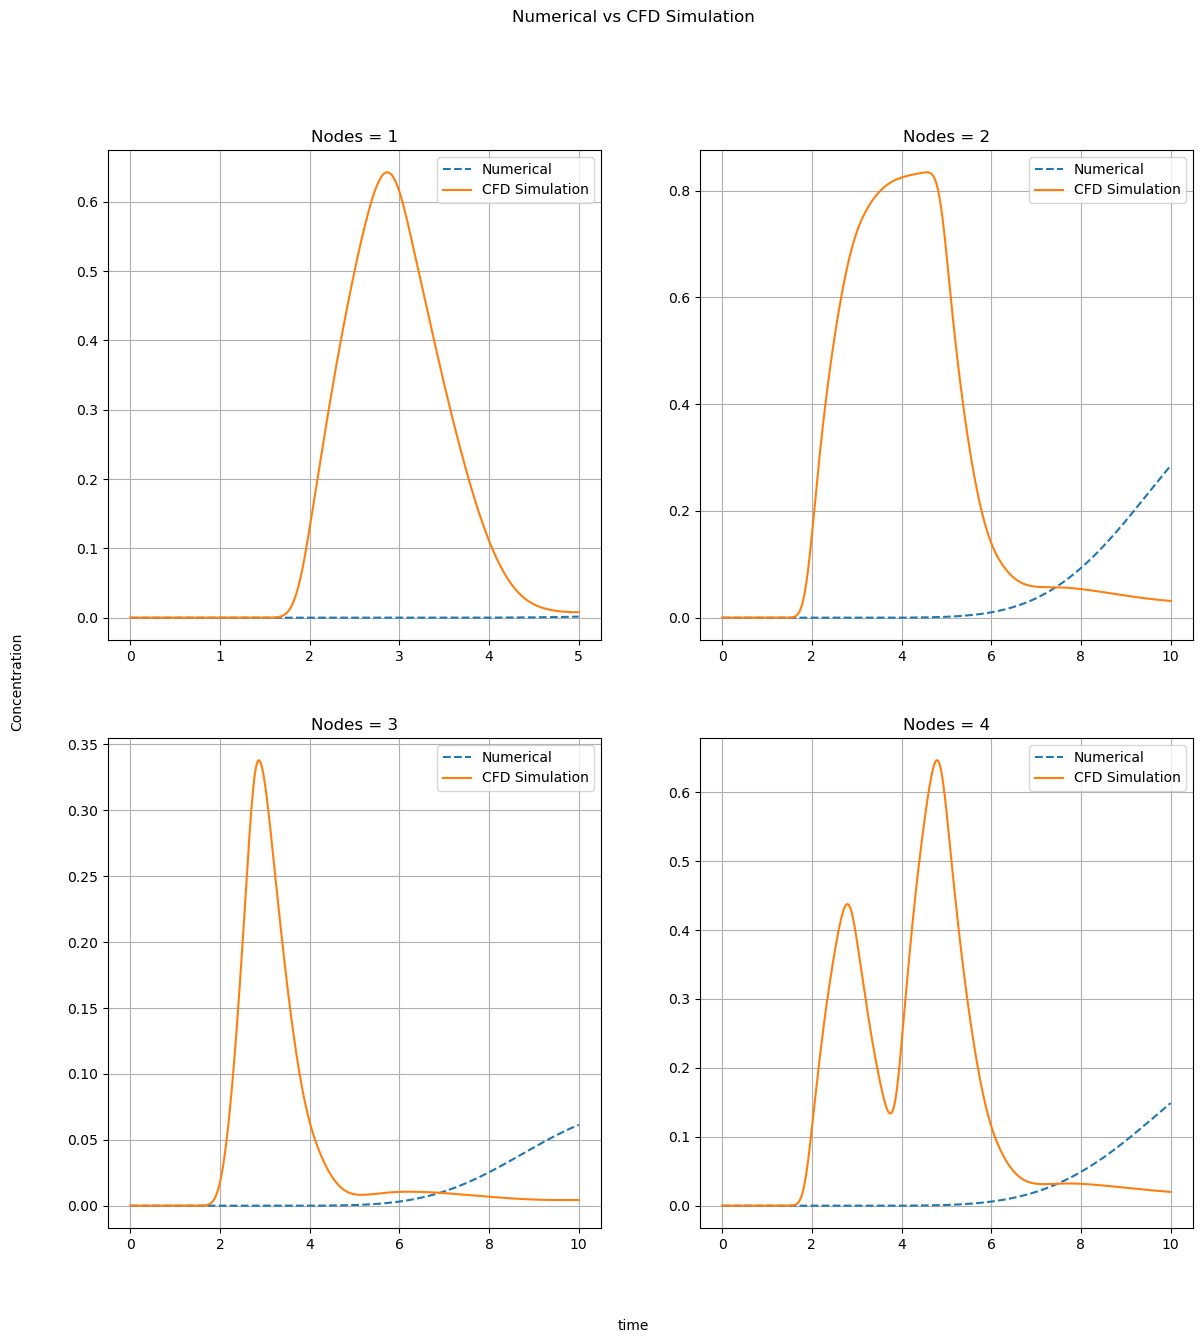

In [36]:
N = [1,2,3,4]
total_time = [5, 10, 10, 10]
fig, axs = plt.subplots(2,2, figsize = (14,14))
fig.suptitle('Numerical vs CFD Simulation')
fig.text(0.5, 0.04, 'time', ha='center', va='center')
fig.text(0.06, 0.5, 'Concentration', ha='center', va='center', rotation='vertical')
# Making subplots for different step sizes
i = 0
while i < len(N):
    n = 17
    Cini = np.zeros(n)
    time_step = 0.02
    V_total = 11.45
    OD = ODE_solver(n, total_time[i], time_step, V_total, Cini)
    t, s = OD.solver('rk4', N[i])
    CFD = OD.Aneurysm_Data(N[i])

    if i == 0:
        axs[0, 0].plot(t, s, '--', label = 'Numerical')
        axs[0, 0].plot(CFD['Time'], CFD['Concentration'], label = 'CFD Simulation')
        axs[0,0].set_title('Nodes = {}'.format(N[i]))
        axs[0,0].legend()
        axs[0,0].grid()
    elif i == 1:
        axs[0, 1].plot(t, s, '--', label = 'Numerical')
        axs[0, 1].plot(CFD['Time'], CFD['Concentration'], label = 'CFD Simulation')
        axs[0, 1].set_title('Nodes = {}'.format(N[i]))
        axs[0, 1].legend()
        axs[0, 1].grid()
    elif i == 2:
        axs[1, 0].plot(t, s, '--', label = 'Numerical')
        axs[1, 0].plot(CFD['Time'], CFD['Concentration'], label = 'CFD Simulation')
        axs[1, 0].set_title('Nodes = {}'.format(N[i]))
        axs[1, 0].legend()
        axs[1, 0].grid()
    elif i == 3:
        axs[1, 1].plot(t, s, '--', label = 'Numerical')
        axs[1, 1].plot(CFD['Time'], CFD['Concentration'], label = 'CFD Simulation')
        axs[1, 1].set_title('Nodes = {}'.format(N[i]))
        axs[1, 1].legend()
        axs[1, 1].grid()
    i+= 1

After tuning the CSTR model with n=23 tanks and tau=2.45 to best fit the Aneurysm_rect_1s.csv CFD data, forecasts were made to predict the sick aorta flow results from the rect_3s, ramp_1s, and biphasic injection protocols; however, the results shown above were much less accurate than for the healthy case. We can see that the peak concentrations are not as high for the model versus CFD results, while on the tail end the CFD results are higher that the baseline zero for an extended period of time before they finally drop to zero.  This could be an indication that the model does not full capture the actualy fluid flow situation and could justify introducing an additional parameter.

#### Part 3

The number of compartments was roughly half for the aneurysm vs. healthy case.  This makes sense since the aneurysm will have large low velocity pockets that trap some of the injection tracer and prevent the peak from going as high, and then those pockets will release that tracer slower which will extend the tracer concentration on th down slope. In order to have a shoter and fater concentration distribution, fewer tanks are required as shown curves in the project

## Abstract

### How did we work?
Basically, we worked on project in the group room, alongside with the lab classes which helped us a lot to discuss about the problems as well as finding the solution. We worked together even if any of us find any solution then we discussed about this and then came to a proper solution which looked like a good way of learning for us. Before finalizing any problem's solution, we together ended up with a good solution and agreed upon that. One of the difficulties that we had in this project was time management, as the time was mostly used on debugging, and that is the reason we didnt invest our time on write the code in the most effective way. 

Tapas created most of the coding and worked on finding the solutions to the problem in theoretical matter. Taz and Jason worked also on the theorectical matter proofs final Python code. Mussa wrote some parts of code of Python code and acted as Project Manager by compiling the individual contributions into a final product.

What we did in the project?
We evaluated the analtical, numerical and line-source solution with two different boundary conditions and also found out the error between them by visuallizing the graphs. Then we matched our well test data from the provided file.

### Our Learnings?

Computational fluid dynamics (CFD) is a powerful tool which utilizes the Navier-Stokes equations to model fluid flow. Some very large CFD models with fine resolution can be impossible to solve in a reasonable amount of time. This project investigates whether a numerical analysis model based on a series well-mixed continuously stirred tank reactors (CSTRs) can be used to produce similar results as CFD for the fluid flow in a healthy and sick aorta arch.

First off an ordinary differential equation (ODE) solver is built into a custom class which utilizes the Euler's, Runge-Kutta second order, and Runge-Kutta fourth order methods to approximate an ODE function passed as a argument. The three solver methods are then tested against the known analytical solutions for one, two, and three CSTRs in series, and the numerical errors for the last tank at time t=1 are plotted which scaled as expected. Secondly, the several variable injection rates are applied to the CSTR model, the model is tuned for the 1s rectangular pulse injection protocol results for a healthy aorta, and predictions are made about three other injection protocols. Thirdly, the CSTR model is re-tuned for the 1s rectangular pulse injection protocol results for a aorta with an aneurysm, and predictions are made for other protocols.

The numerical errors of the ODE solver scaled as expected with the 4th order Runge-Kutta method being the most accurate and the Euler method being the least accurate. The rect_1s best fit healthy model used n=29 tanks with very good results, while the initial best fit sick model used n=23 tanks with decent results, and after adding a diffusion factor the best fit was achieved using n=30 tanks with good results.

The CSTR approach is a effective model for small scale fluid flow situation that can accurate replicate CFD results when the right parameters are chosen and properly tuned.

## Conclusion

A series of well-mixed continuously stirred tank reactors (CSTR) can be used to create an effective model to recreate fluid flow in a healthy aorta from computational fluid dynamics (CFD) simulations. The fluid flow rate was determined to be 5 litre/min by dividing the total mass injected by the integration of the Healthy_rect_1s.csv concentrations. The moderate difficulty method with scipy.optimize.curve_fit was used to find that the best match of CSTR model to the Healthy_rect_1s.csv data had n=49 tanks and tau=2.3655 therefore the Vtot = 11.83 l. These tuned parameters were used to forecast the results from the rect_3s, ramp_1s, and biphasic injection protocols with good accuracy. A possible next step for validating this model would be to compare the results against actual medical data instead of CFD simulated results.

## References

1) Aksel Hiorth. Computational Engineering and Modeling, 2021
   https://github.com/ahiorth/CompEngineering